# Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

In [3]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(features)]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    return model

def plot_history(models):
    k = len(models)
    
    fig, axs = plt.subplots(nrows=(k+1)//2, ncols=2, figsize=(16,30))
    
    for i, ax in enumerate(axs.flat):
        if i >= k:
            break
        
        history = models[i][1]
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
    
        ax.set_title(f'Model {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        
        ax.plot(hist['epoch'], hist['loss'], label='Train loss')
        ax.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
        ax.set_ylim([0,1])
        ax.legend()

    plt.show()
    
def get_mean_mse(models):
    total_loss = 0
    for model in models:
        total_loss += model[2]
    return total_loss / len(models)

def get_best_model(models):
    min_loss, ind = float('inf'), -1
    for i, model in enumerate(models):
        if model[2] < min_loss:
            min_loss = model[2]
            ind = i
    return models[ind][0]

In [4]:
def compare_results(targets, y_limits, model_name):
    
    target = targets[0]
    predicted = targets[1]
    # Compare target and predicted values
    plt.figure(figsize=(10, 6));
    sns.regplot(x=target, y=predicted, marker="*", scatter_kws={"s": 80}, ci=68);
    plt.xlabel('Target price');
    plt.ylabel('Predicted price');
    plt.title('Predicted vs. target - ' + model_name)
    
    # Visualize prediction difference
    prediction_diff = target - predicted
    plt.figure(figsize=(10, 6));
    sns.scatterplot(np.arange(prediction_diff.shape[0]), prediction_diff, 
                    marker="*", s=150);
    plt.axhline(y=0, color='r', linestyle='-');
    plt.axhline(y=prediction_diff.mean(), color='m', linestyle='--');
    plt.ylim(y_limits[0], y_limits[1]);
    plt.xlabel('Target price');
    plt.ylabel('Target - Prediction');
    plt.title('diff(target, prediction) - ' + model_name)
    
    
def visualize_data(pca_data, targets, model_name, dr_type):
    
    # Visualize first PCs
    fig, axes = plt.subplots(1, 2, figsize=(18, 6));
    
    for idx, axis in enumerate(axes):
        sns.scatterplot(pca_data[:, 0], pca_data[:, 1],
                        marker="o", hue=targets[idx], s=100, ax=axis);
        axis.set_xlabel(dr_type + ' 1');
        axis.set_ylabel(dr_type + ' 2');
        axis.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False);
        if idx == 0:
            axis.set_title(dr_type + ' scores - target prices')
        else:
            axis.set_title(dr_type + ' scores - predicted prices, ' + model_name)
    
    
def perform_pca(data):
    # Scale data and perform PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    pca_model = PCA(n_components=0.95)
    data_pca = pca_model.fit_transform(data_scaled)
    return data_pca

# Cleaning catalog

In [5]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows.')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows.')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows.
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows.
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows.
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows.
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows.

Totally removed 135 rows.


In [6]:
removed_tanks

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,46145,lightTank,0,0,10,1
1,46353,heavyTank,0,0,10,1
2,57857,mediumTank,0,1,1,1
3,59921,SPG,0,0,1,0
4,65025,lightTank,0,0,1,1
...,...,...,...,...,...,...
130,42753,mediumTank,915000,0,2,5
131,42769,lightTank,500,0,2,3
132,43009,lightTank,38500,0,2,3
133,43265,lightTank,39300,0,2,2


In [7]:
classEncoder = LabelEncoder()

catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


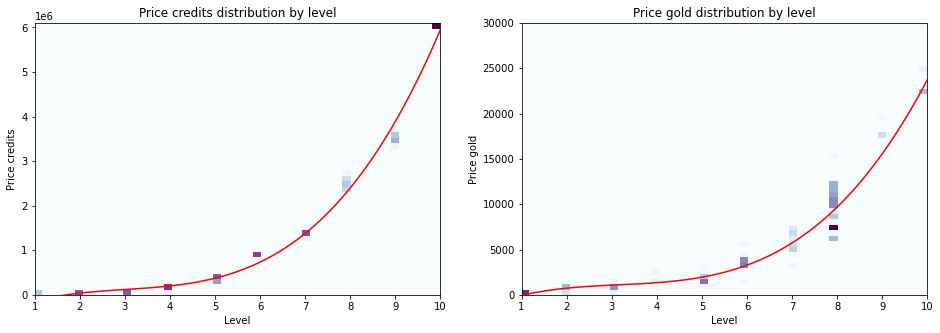

In [8]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

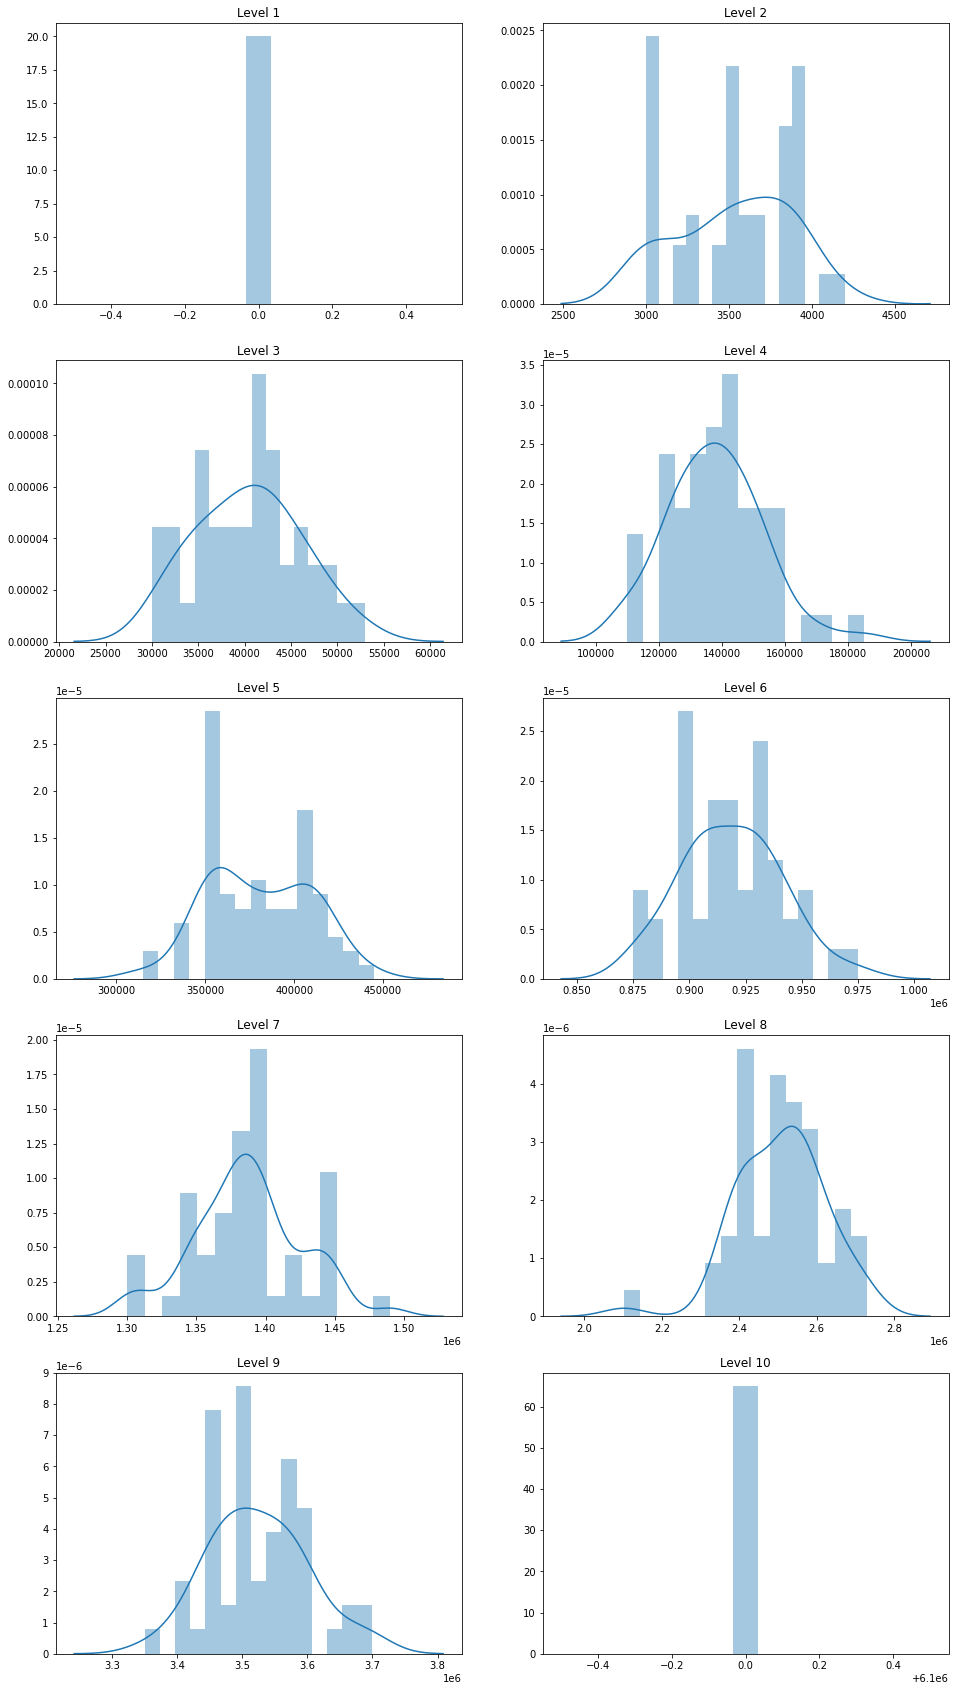

In [9]:
price_ditributions(creds_catalog, price='creds')

In [10]:
# --> no duplicates
catalog.duplicated().sum()

0

In [11]:
# --> no missing values
catalog.isnull().sum()

item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64

#  Looking on removed tanks

In [12]:
s1 = set(removed_tanks['item_cd'])
s2 = set(data['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{6225, 13889, 9297, 65281}


In [13]:
removed_tanks[removed_tanks['item_cd'] == 9297]

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
18,9297,AT-SPG,0,5,10,5


In [14]:
data[data['vehicle_type_cd'] == 9297]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
259,2018-10-27,4yNy1TNaa7yd71T4c,cdcyd44Ta,2,500019571,0,0,9297,365,5,...,1226,0,22046,384,15,10,34065,1270,0,0
3252,2018-10-17,424y7TyaNcyyT4cTy,cyNy71y2c,2,500135958,0,0,9297,415,5,...,1117,0,34650,622,15,10,41198,1400,0,201
3269,2018-10-17,424y7TyaNcyyT4cTy,c2yyN4a22,1,500040230,0,0,9297,477,9,...,1339,1330,104877,4430,15,20,22696,1140,34959,869
3498,2018-10-17,424y12T24Ny22TTTa,cyyT1T4cN,1,500159862,0,0,9297,656,8,...,2342,874,52922,1646,15,10,51289,0,0,0
3653,2018-10-17,424y7yd21cddc7cdd,c2yTNddca,2,500069934,0,0,9297,323,3,...,1267,2000,18123,1488,15,20,38614,390,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377598,2018-10-17,21cN2N1TydaT1dc27,cdyc7TddN,1,500012667,0,0,9297,356,6,...,1181,1237,38034,2189,15,20,66027,390,0,0
1383488,2018-10-17,24Ndc74a7NcyTTTNN,ca2adcNd2,2,500004709,0,0,9297,281,3,...,528,0,25070,412,15,10,33198,240,8357,0
1386077,2018-10-26,12ac27ycN147ad7,cdaa1TTdy,2,0,0,0,9297,433,1,...,1512,370,11817,2368,15,40,45529,400,0,469
1394142,2018-10-17,a2adaNdTcTTNd1Naa,cdacaT4Tc,2,500156864,0,0,9297,290,4,...,797,1713,24936,891,15,10,29711,0,0,0


# Visualizing catalog

In [15]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

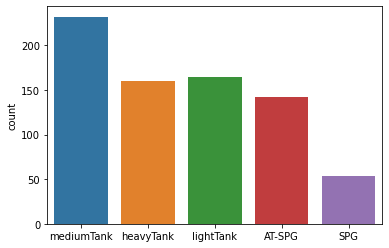

In [16]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

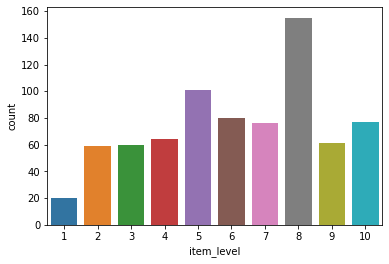

In [17]:
sns.countplot(catalog['item_level']);

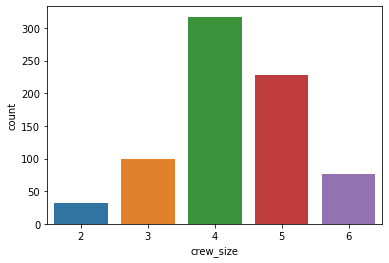

In [18]:
sns.countplot(catalog['crew_size']);

# Cleaning data

## Removing entries from "data" that corresponds to deleted tanks in "catalog"

In [19]:
data.head()

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,459,-3,27279,1084,15,20,11956,0,0,0
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,708,0,6282,68,15,10,9832,0,0,0
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,656,0,36102,3560,15,20,39190,0,0,1130
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,1912,387,16317,1678,15,20,7217,0,0,0
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,507,0,11620,232,15,10,9532,0,0,0


In [20]:
mask = ~data['vehicle_type_cd'].isin(removed_ids)

removed_data = data.loc[~mask]
data = data.loc[mask]

data.reset_index(inplace=True, drop=True)
removed_data.reset_index(inplace=True, drop=True);

In [21]:
data

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,459,-3,27279,1084,15,20,11956,0,0,0
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,708,0,6282,68,15,10,9832,0,0,0
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,656,0,36102,3560,15,20,39190,0,0,1130
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,1912,387,16317,1678,15,20,7217,0,0,0
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,507,0,11620,232,15,10,9532,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402953,2018-10-11,1ccdcTcya4T7Nyc,cac4aa12N,2,500150344,5640480,0,1921,364,9,...,2161,425,77063,2532,15,20,13638,0,0,0
1402954,2018-10-11,1ccdcTcya4T7Nyc,cdTcc72Nc,1,500138824,5288203,0,913,311,6,...,1126,0,34367,294,15,10,14741,760,0,0
1402955,2018-10-11,1ccdcTcya4T7Nyc,cd42c2TTT,1,500154303,5288203,0,50193,174,2,...,485,0,10361,90,15,10,29797,0,0,0
1402956,2018-10-11,1ccdcTcya4T7Nyc,cd4a7Tc72,2,500156478,5640480,0,51361,136,7,...,760,0,48382,740,15,10,41982,0,0,0


## Checking duplicates and missing values

In [22]:
data.duplicated().sum()

0

In [23]:
data.isnull().sum()

dt                          0
arena_id                    0
account_db_id               0
team_id                     0
clan_db_id                  0
prebattle_id                0
is_prebattle_creator        0
vehicle_type_cd             0
life_time_sec               0
shots                       0
hits                        0
he_hits                     0
pierced                     0
damage_dealt                0
damage_assisted_radio       0
damage_assisted_stun        0
damage_assisted_track       0
damage_received             0
shots_received              0
no_damage_shots_received    0
pierced_received            0
spotted                     0
damaged                     0
kills_made                  0
mileage_meter               0
remained_hp                 0
original_credits            0
original_xp                 0
premium_xp_factor           0
daily_xp_factor             0
battle_num                  0
damage_blocked_by_armor     0
booster_bonus_credits       0
booster_bo

## Checking outliers

In [24]:
def calculate_z_score(data):
    return stats.zscore(data)

Something does not work here, check later

In [25]:
# features = data.columns.values
# z_scores = np.zeros((data.shape[0], len(features)))
# z_score_threshold = 3

# feature_outliers = dict.fromkeys(features)

# # z-scores for old features
# for index, feature in enumerate(features):
#     feature_outliers = calculate_z_score(data[feature])
    
#     z_scores[:, index] = feature_outliers
#     feature_outliers[feature] = data[feature_outliers > z_score_threshold]
    
#     print(feature, feature_outliers[feature].shape[0])
    
#     # Plotting feature distribution
#     fig, ax = plt.subplots()
#     sns.distplot(data[feature], kde=False);
#     plt.axvline(feature_outliers[feature][feature].min(), ymin=0, ymax=ax.get_ylim()[1])

## Removing players that did not do anything in the battle

In [26]:
data[data['mileage_meter'] == 0]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
1161,2018-10-12,yT7NTyTTNacdy2114,cayy4Ny4c,1,0,0,0,54289,314,0,...,0,0,0,0,15,10,14432,0,0,0
1347,2018-10-12,yT7NT7cydcdcTcN22,cdac74Ny7,1,500045571,0,0,61969,409,0,...,0,1200,15600,817,15,20,10850,0,0,0
1826,2018-10-12,yN7yN44T2ad72TdT2,c2N1a242c,2,500062516,0,0,9217,352,0,...,0,1550,23400,626,15,10,10607,0,0,0
1924,2018-10-12,4ca24cy4ad174T2,c4Ta7dyTy,2,500154035,0,0,3137,377,0,...,0,0,13044,856,15,20,17271,0,0,0
2321,2018-10-15,yd7Tyay2c1ccyNNTN4,c4421d2dT,1,0,0,0,20481,351,0,...,0,0,0,13,15,10,19822,1030,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401093,2018-10-11,1ccay42yycdaNd1,c44d4a144,1,0,0,0,2849,149,1,...,0,0,14836,227,15,10,15356,0,0,0
1401939,2018-10-11,1c2N7a4c4a274N1,cd2d42247,1,500030969,0,0,2465,456,0,...,0,0,12636,1638,15,20,44097,0,0,546
1402151,2018-10-11,1ca212TNyN7aa71,cyy7444c2,1,0,0,0,18177,559,0,...,0,1300,7839,766,15,20,12950,0,0,0
1402435,2018-10-11,1cydd2dT4aaNcNN,cc2yTc2aa,2,500156798,0,0,56657,274,0,...,0,-3,22680,175,15,10,7181,0,0,0


# Visualizing data

In [27]:
for feature in ['arena_id', 'account_db_id', 'team_id', 'clan_db_id', 
               'prebattle_id', 'is_prebattle_creator', 'vehicle_type_cd']:
    data[feature] = pd.Categorical(data[feature])
    
data['dt'] = pd.to_datetime(data['dt'])

## dt

All battles took place in October 2018 (between October 1 and October 31)

In [28]:
data['dt'].describe()

count                 1402958
unique                     31
top       2018-10-10 00:00:00
freq                    90939
first     2018-10-01 00:00:00
last      2018-10-31 00:00:00
Name: dt, dtype: object

## arena_id

47.363 unique battles were held.

45.479 battles should be 15 vs. 15 players!

There were 30 players in most battles (30 -> 20 -> 14). 
However, in some battles, a number of players was either odd (19, 13) or 
strangely small (2, 4). Are those battles connected to special events?

In [29]:
battles = data['arena_id'].value_counts()
battles

yyyyd1d41y77yN4      30
4TNN1T2TdT12d7y7a    30
4TNN1T1TyN77TNadc    30
4TNN1Nya1ayd274N2    30
4TNN1Ny1y2cNTcTaN    30
                     ..
424y1a22T2d7T11a7     4
71a1daddT4yN4c7       4
Ty7cc77dTNNd7N4       3
Ty72acc1444a4d1       3
4d2721ay1a7c11Nya     2
Name: arena_id, Length: 47363, dtype: int64

In [30]:
battles.to_frame()['arena_id'].value_counts()

30    45479
20     1033
14      417
29      373
28       26
19        8
27        5
13        5
12        4
18        3
3         2
4         2
6         1
17        1
7         1
21        1
24        1
2         1
Name: arena_id, dtype: int64

## account_db_id

367.685 unique players took part in battles.

In [31]:
data['account_db_id'].value_counts()

c2aTcT4y4    214
cdNcaNN77    201
c277NNN2y    140
cadaaNc77    121
c4NacTcc4     98
            ... 
cdN1a12cT      1
cdN1Ty4y2      1
cdN1Ty212      1
cdN1Tdc1y      1
c2111224a      1
Name: account_db_id, Length: 367685, dtype: int64

## life_time_sec

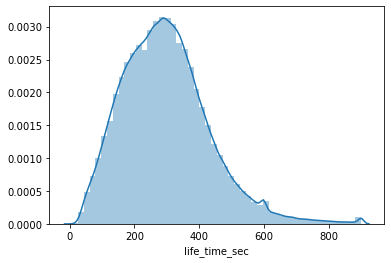

In [32]:
sns.distplot(data['life_time_sec']);

## remained_hp

In [33]:
data_negative_hp = data[data['remained_hp'] < 0]
data_negative_hp.shape[0]

116697

## damage_dealt (total, assisted, etc.)

There are 1549 rows in a dataset that correspond to so-called "away-from-keyboard" players

In [34]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

In [35]:
data[(data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,total_damage_dealt
1161,2018-10-12,yT7NTyTTNacdy2114,cayy4Ny4c,1,0,0,0,54289,314,0,...,0,0,0,15,10,14432,0,0,0,0
1347,2018-10-12,yT7NT7cydcdcTcN22,cdac74Ny7,1,500045571,0,0,61969,409,0,...,1200,15600,817,15,20,10850,0,0,0,0
1826,2018-10-12,yN7yN44T2ad72TdT2,c2N1a242c,2,500062516,0,0,9217,352,0,...,1550,23400,626,15,10,10607,0,0,0,0
2321,2018-10-15,yd7Tyay2c1ccyNNTN4,c4421d2dT,1,0,0,0,20481,351,0,...,0,0,13,15,10,19822,1030,0,0,0
2357,2018-10-15,NTaNNTyd4Nd4a1dN1,c4aN4y4T2,2,0,0,0,13137,398,0,...,0,0,0,15,10,19541,560,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400356,2018-10-11,1ca271aN7dd4cNd,cc2yTc2aa,1,500156798,0,0,57121,165,0,...,0,13230,130,15,10,7179,180,0,41,0
1400503,2018-10-11,1cyaN72dya2N214,ca4cc4N21,1,0,0,0,50193,358,0,...,1150,23400,718,15,10,17326,0,0,0,0
1401939,2018-10-11,1c2N7a4c4a274N1,cd2d42247,1,500030969,0,0,2465,456,0,...,0,12636,1638,15,20,44097,0,0,546,0
1402151,2018-10-11,1ca212TNyN7aa71,cyy7444c2,1,0,0,0,18177,559,0,...,1300,7839,766,15,20,12950,0,0,0,0


## original_credits, original_xp, booster_bonus_xp, booster_bonus_credits

There is one player with original_credits < 0.

In [36]:
data[data['original_credits'] < 0]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,total_damage_dealt
683512,2018-10-23,yT1Ny1yc1c77dc17T,cyN1N4Td4,1,500147675,31578326,0,5377,231,3,...,0,-1037,194,15,10,57279,0,0,0,81


# Create new features (normalized to time/etc) 

In [37]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0
    
normalize_feature = np.vectorize(normalize_feature)

## Calculate additive features

In [38]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

data['damage_shots_received'] = data['shots_received'] - data['no_damage_shots_received']

Turns out that data['damage_shots_received'] = data['pierced_received'], so this feature is not added.

## Normalize to time

In [39]:
target_features = ['shots', 'hits', 'he_hits', 'pierced', 'damage_dealt', 
                   'damage_assisted_track', 'damage_assisted_radio', 
                   'damage_assisted_stun', 'total_damage_dealt',
                   'damage_received', 'shots_received', 
                   'pierced_received', 'spotted', 
                   'damaged', 'kills_made', 'mileage_meter',
                   'damage_blocked_by_armor']
# target_features_normalized_sec = [feature + '_per_sec' for feature in target_features]
target_features_normalized_min = [feature + '_per_min' for feature in target_features]

In [40]:
data['life_time_min'] = data['life_time_sec'] / 60

for feature in target_features:
#     data[feature + '_per_sec'] = normalize_feature(data[feature], data['life_time_sec'])
    data[feature + '_per_min'] = normalize_feature(data[feature], data['life_time_min'])

## Normalize to hits, shots, etc.

In [41]:
features_normalized = ['hit_rate', 'he_hit_rate', 'pierced_rate',
                      'damage_per_pierced', 'pierced_received_per_shot', 
                      'damage_per_enemy', 'damage_per_enemy_per_min', 
                      'damage_blocked_per_hit', 'damage_blocked_received_ratio']
features_num = ['hits', 'he_hits', 'pierced', 'damage_received', 
               'pierced_received', 'total_damage_dealt', 'total_damage_dealt_per_min', 
               'damage_blocked_by_armor', 'damage_blocked_by_armor']
features_denom = ['shots', 'hits', 'hits', 'pierced_received', 'shots_received', 
                 'damaged', 'damaged', 'pierced_received', 'damage_received']

In [42]:
for new_feature, feature_num, feature_denom in zip(features_normalized,
                                                  features_num, features_denom):
    data[new_feature] = normalize_feature(data[feature_num], data[feature_denom])

## Compare distributions before and after normalization

### Normalized to life_time_min

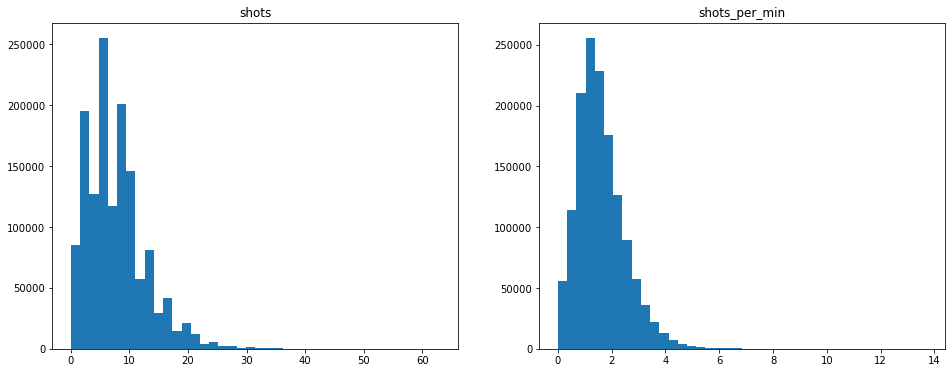

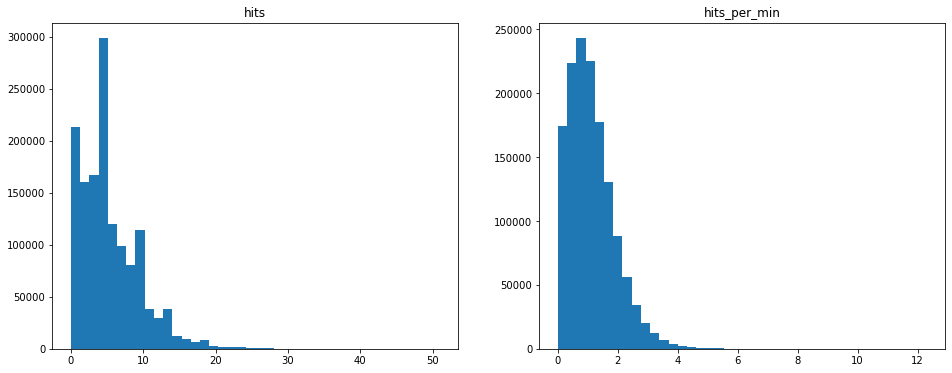

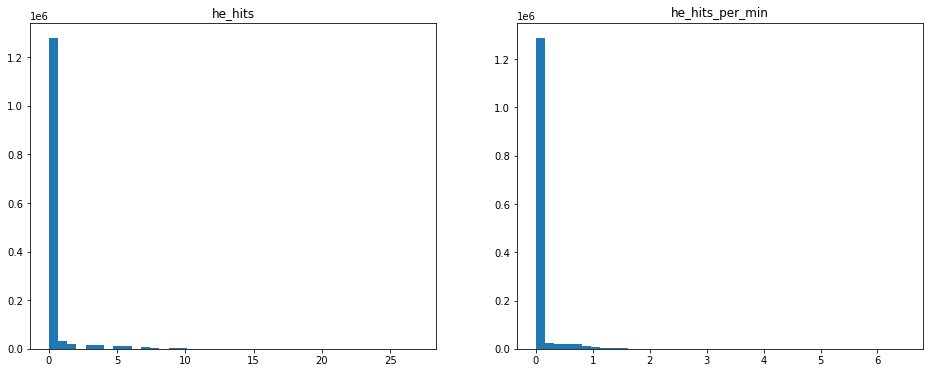

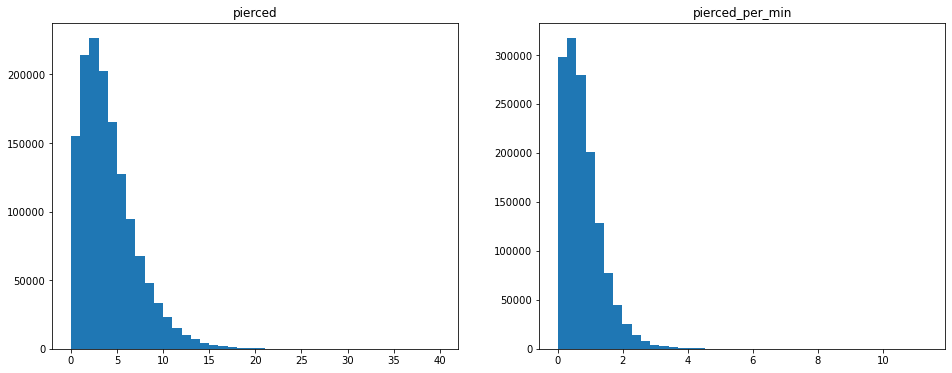

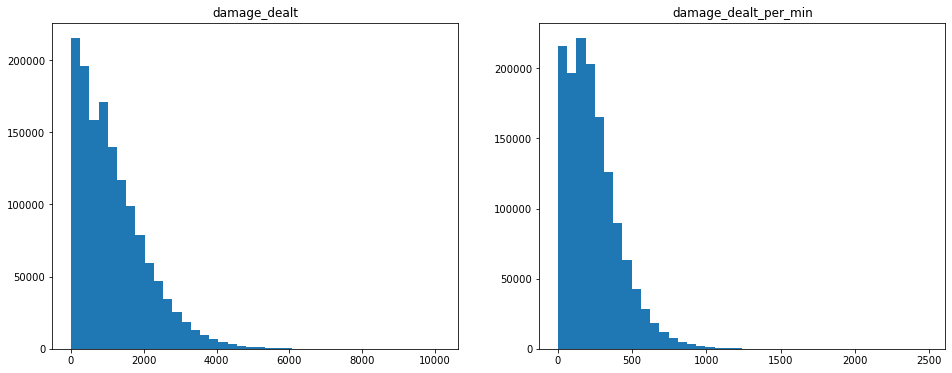

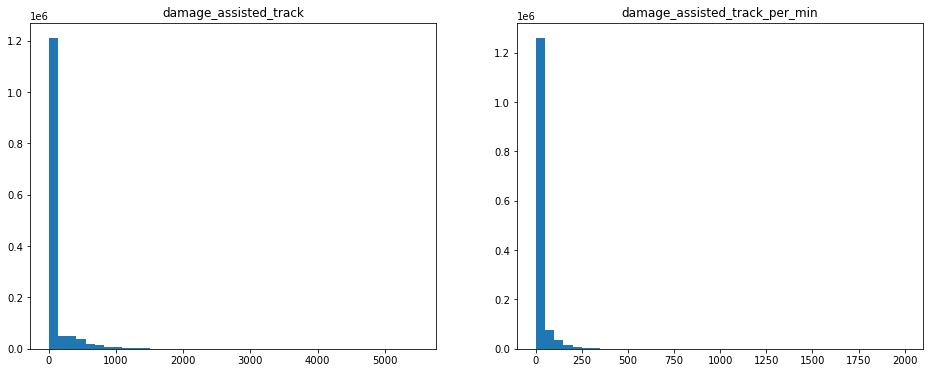

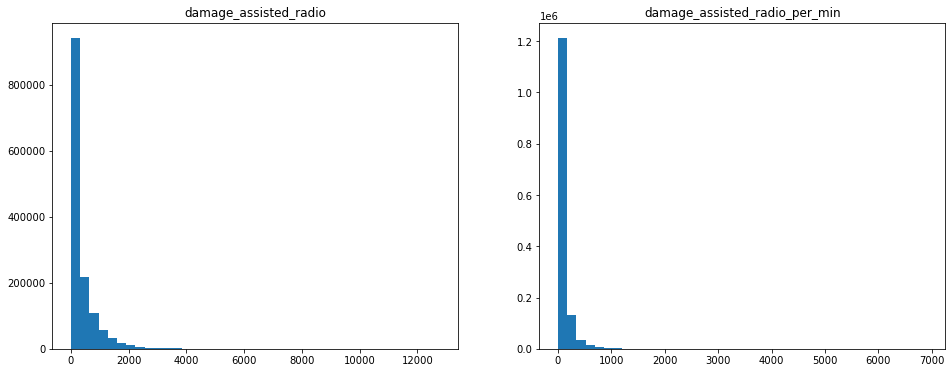

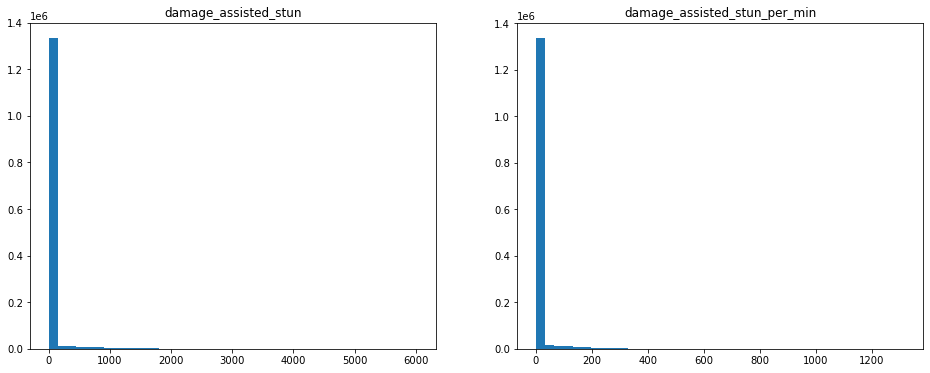

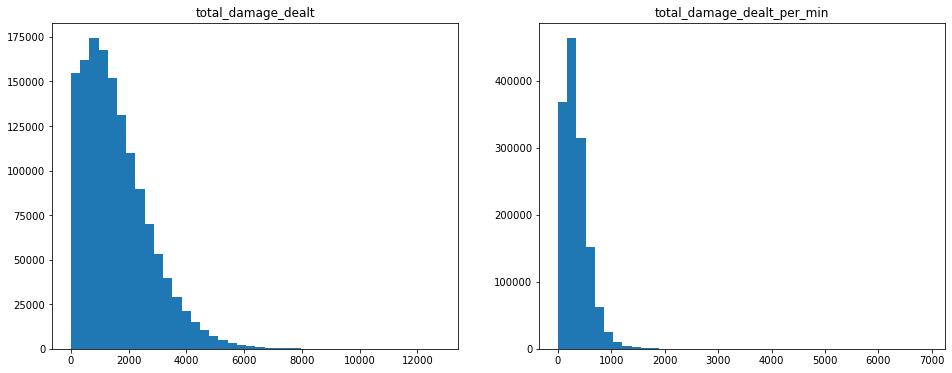

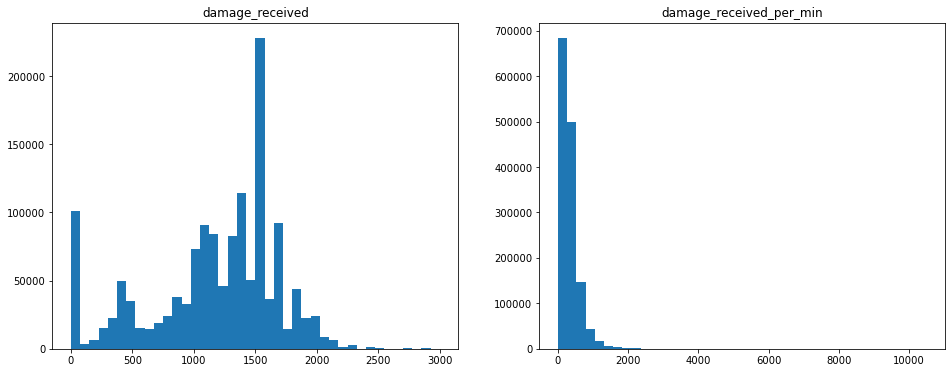

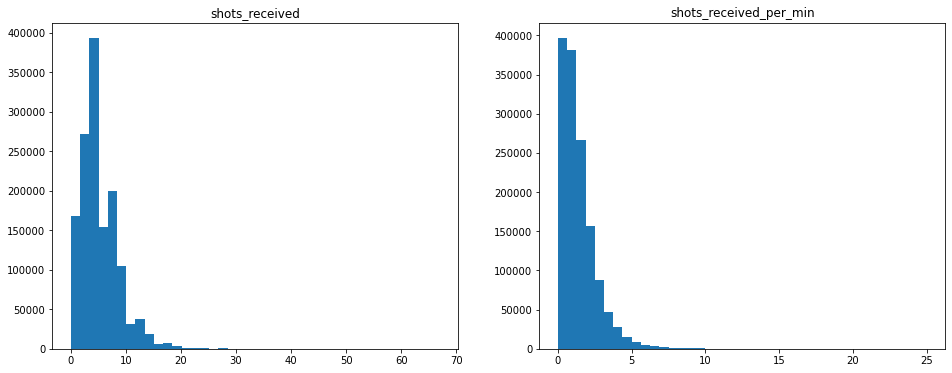

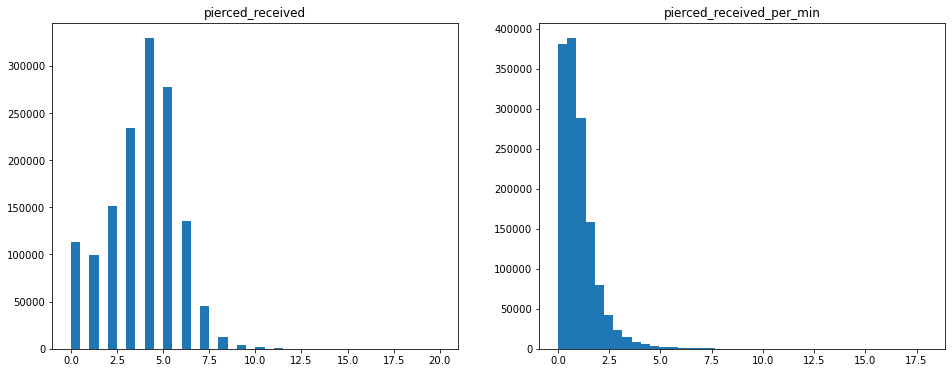

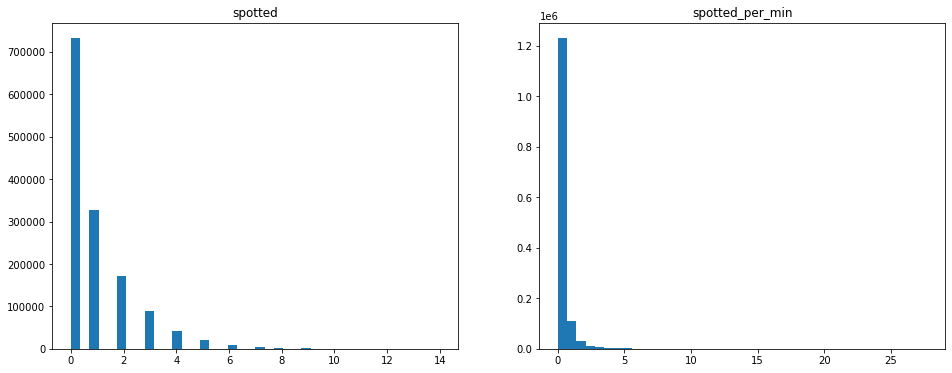

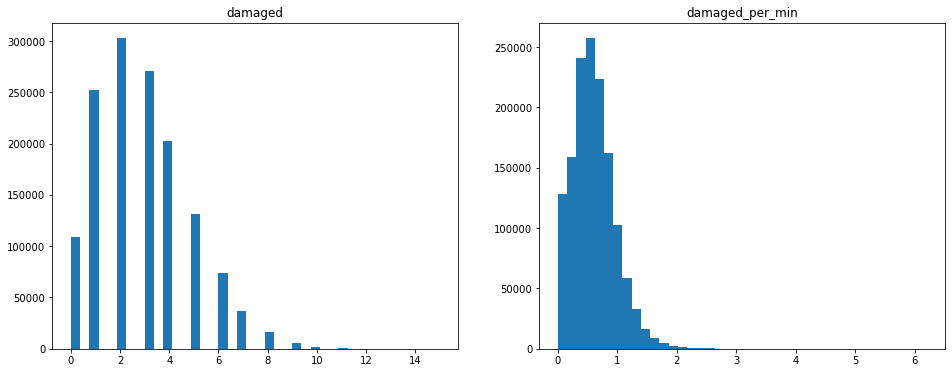

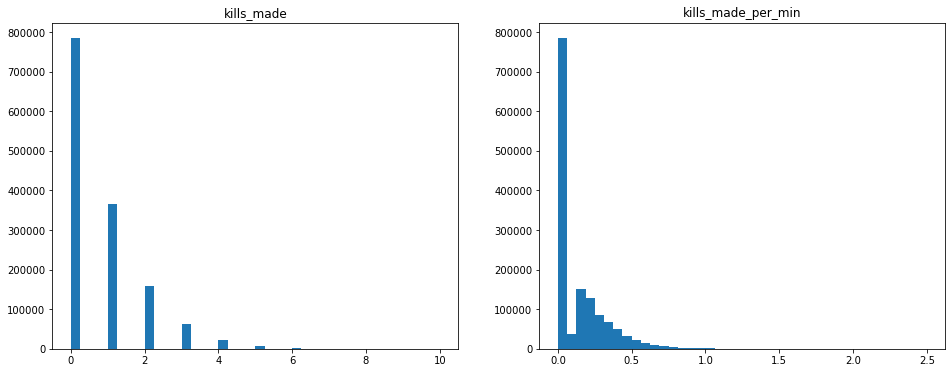

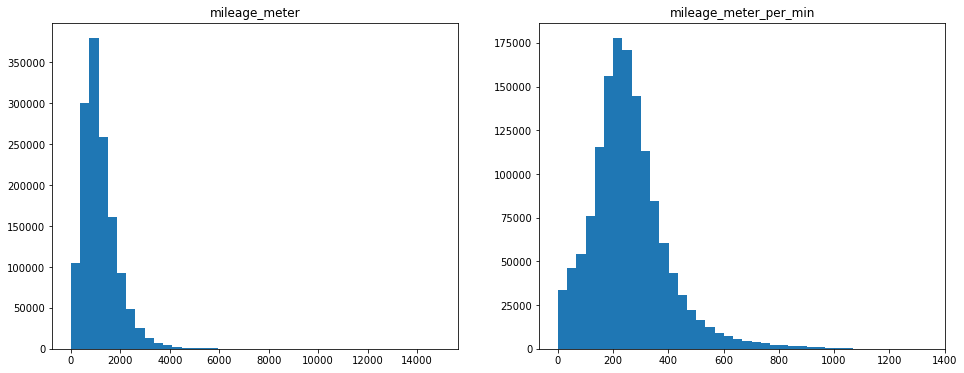

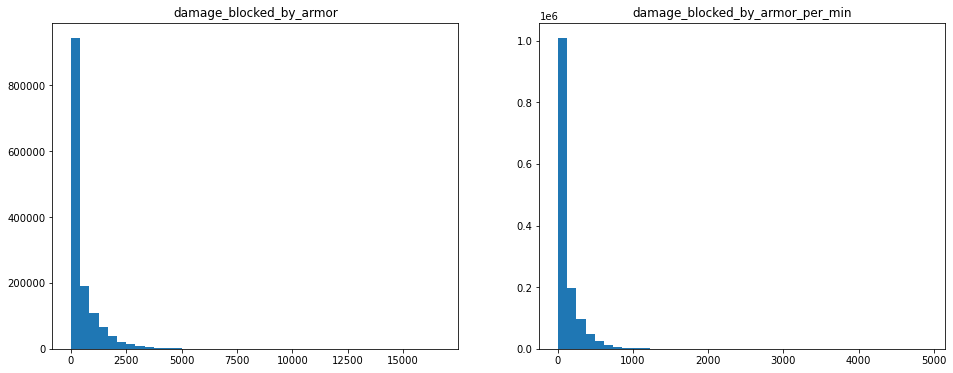

In [43]:
for feature in target_features:
    new_feature = feature + '_per_min'

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].hist(data[feature], bins=40)
    axes[1].hist(data[new_feature], bins=40)
    
    axes[0].set_title(feature)
    axes[1].set_title(new_feature)

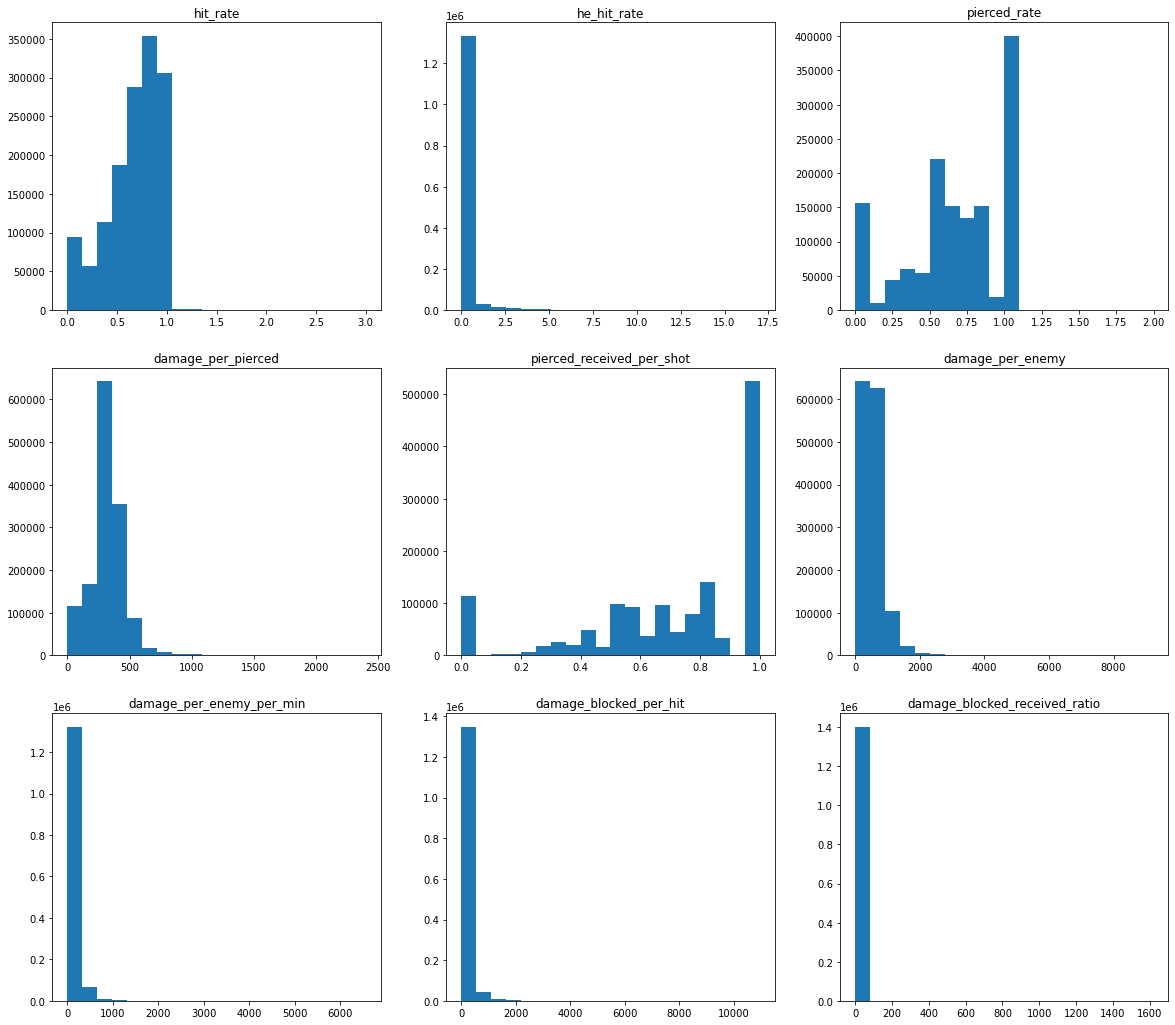

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
axes = axes.ravel()

for index, feature in enumerate(features_normalized):
    axes[index].hist(data[feature], bins=20);
    axes[index].set_title(feature)

# Removing redundant features and outlier rows

## Redundant features

In [45]:
redundant_features = ['dt', 'premium_xp_factor', 'daily_xp_factor', 'battle_num', 'prebattle_id', 'is_prebattle_creator']
data.drop(redundant_features, axis=1, inplace=True)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402958 entries, 0 to 1402957
Data columns (total 56 columns):
arena_id                           1402958 non-null category
account_db_id                      1402958 non-null category
team_id                            1402958 non-null category
clan_db_id                         1402958 non-null category
vehicle_type_cd                    1402958 non-null category
life_time_sec                      1402958 non-null int64
shots                              1402958 non-null int64
hits                               1402958 non-null int64
he_hits                            1402958 non-null int64
pierced                            1402958 non-null int64
damage_dealt                       1402958 non-null int64
damage_assisted_radio              1402958 non-null int64
damage_assisted_stun               1402958 non-null int64
damage_assisted_track              1402958 non-null int64
damage_received                    1402958 non-null int64
sh

## Outliers

In [47]:
# Removing "away-from-keyboard" players
afk_players = (data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)
data = data.loc[~afk_players]
data.reset_index(inplace=True, drop=True)

# Joining data

In [48]:
joined_data = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
joined_data

,arena_id,account_db_id,team_id,clan_db_id,vehicle_type_cd,life_time_sec,shots,hits,he_hits,pierced,...,damage_per_enemy,damage_per_enemy_per_min,damage_blocked_per_hit,damage_blocked_received_ratio,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,4yNy14y4yN12d42dT,c42c4aydT,2,0,2849,132,3,2,0,2,...,341.000000,155.000000,0.000000,0.000000,2849,2,0,12000,8,6
1,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,63553,195,6,3,0,1,...,424.000000,130.461538,0.000000,0.000000,63553,4,0,7450,8,4
2,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,17665,224,11,10,0,7,...,518.500000,138.883929,0.000000,0.000000,17665,4,3450000,0,9,4
3,4yNy14y4yN12d42dT,c2cdc441y,2,0,11537,381,8,5,0,4,...,268.750000,42.322835,0.000000,0.000000,11537,0,2570000,0,8,5
4,4yNy14y4yN12d42dT,cdT7cTT21,1,0,7937,198,5,3,0,2,...,523.000000,158.484848,0.000000,0.000000,7937,4,3450000,0,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401404,1ccdcTcya4T7Nyc,cac4aa12N,2,500150344,1921,364,9,6,0,6,...,992.000000,163.516484,0.000000,0.000000,1921,2,2540000,0,8,3
1401405,1ccdcTcya4T7Nyc,cdTcc72Nc,1,500138824,913,311,6,5,0,5,...,735.666667,141.929260,126.666667,0.506667,913,2,0,10700,8,4
1401406,1ccdcTcya4T7Nyc,cd42c2TTT,1,500154303,50193,174,2,1,0,1,...,818.000000,282.068966,0.000000,0.000000,50193,0,0,10900,8,4
1401407,1ccdcTcya4T7Nyc,cd4a7Tc72,2,500156478,51361,136,7,6,0,4,...,324.250000,143.051471,0.000000,0.000000,51361,4,0,11000,8,4


In [49]:
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401409 entries, 0 to 1401408
Data columns (total 62 columns):
arena_id                           1401409 non-null category
account_db_id                      1401409 non-null category
team_id                            1401409 non-null category
clan_db_id                         1401409 non-null category
vehicle_type_cd                    1401409 non-null int64
life_time_sec                      1401409 non-null int64
shots                              1401409 non-null int64
hits                               1401409 non-null int64
he_hits                            1401409 non-null int64
pierced                            1401409 non-null int64
damage_dealt                       1401409 non-null int64
damage_assisted_radio              1401409 non-null int64
damage_assisted_stun               1401409 non-null int64
damage_assisted_track              1401409 non-null int64
damage_received                    1401409 non-null int64
shots

In [50]:
joined_data.drop(['item_cd'], axis=1, inplace=True)

# Correlations

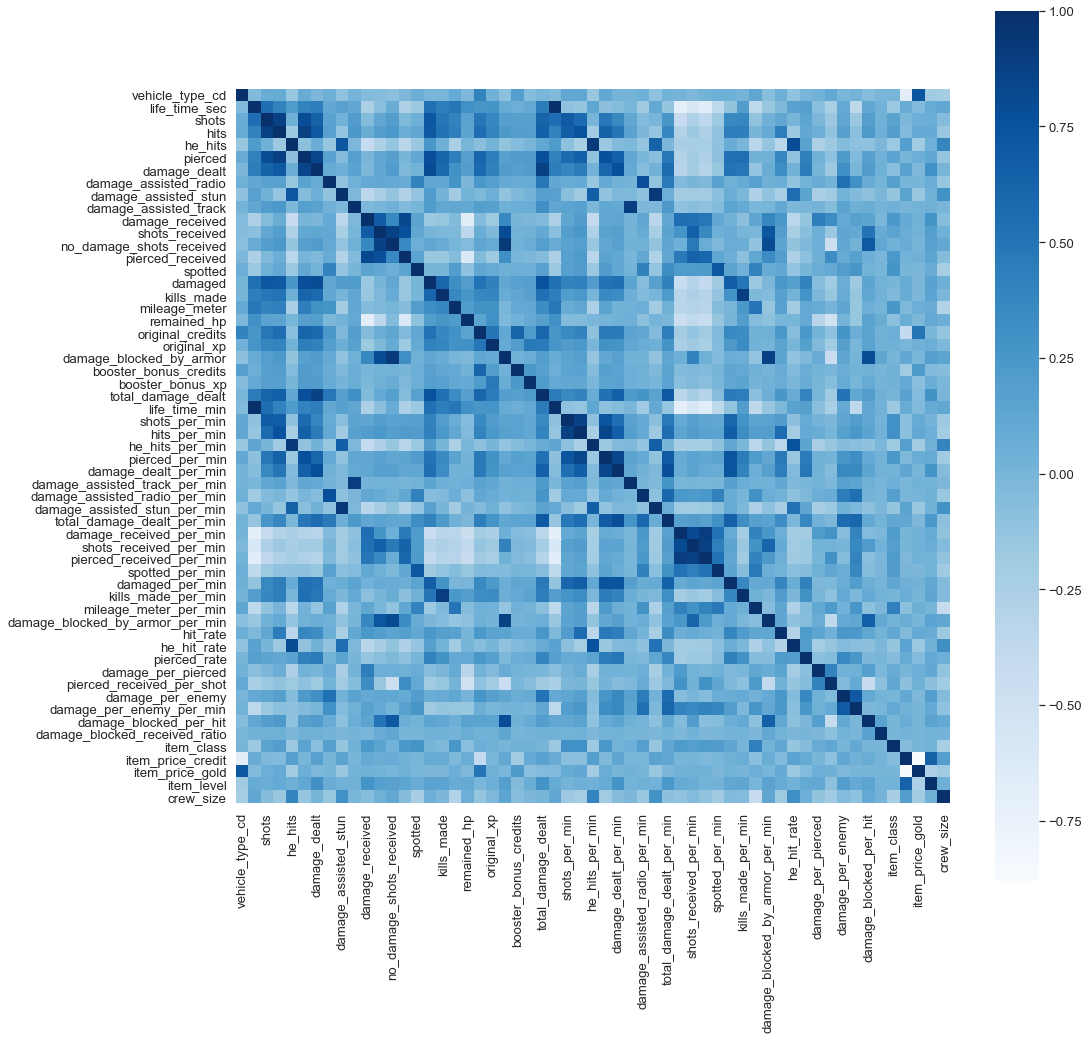

item_price_credit                 -0.879614
item_level                        -0.257855
he_hits_per_min                   -0.197234
he_hits                           -0.191856
crew_size                         -0.190523
he_hit_rate                       -0.155867
damage_assisted_stun              -0.150263
damage_assisted_stun_per_min      -0.147674
booster_bonus_xp                  -0.081860
pierced_rate                      -0.045623
total_damage_dealt                -0.043505
life_time_sec                     -0.039919
life_time_min                     -0.039919
damage_per_enemy                  -0.026827
damage_dealt                      -0.025361
remained_hp                       -0.023703
total_damage_dealt_per_min        -0.018401
damaged                           -0.017148
spotted_per_min                   -0.015807
kills_made                        -0.015223
spotted                           -0.012663
damage_blocked_by_armor           -0.011939
damage_per_enemy_per_min        

In [51]:
sns.set(font_scale=1.2)

corr = joined_data.corr()

plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model (Egor)

In [52]:
res_data = joined_data.groupby('vehicle_type_cd').mean().reset_index()
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

features = ['item_level', 'item_class', 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits']
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

gold_dataset

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits,item_price_gold
0,8.0,4,1064.448289,1240.813987,51679.194516,0.684068,0.0,0.007712,4.0,6.975084,5389.571946,7500.0
1,6.0,4,416.653846,948.333333,20239.653846,0.371795,0.0,0.025641,5.0,5.538462,1028.179487,3650.0
3,7.0,3,637.982659,1177.310694,33927.674855,0.567919,0.0,0.005780,4.0,5.426301,2376.382948,4800.0
7,8.0,2,1047.733147,1162.089166,45393.871850,0.619212,0.0,0.090890,4.0,5.424079,4235.036399,12250.0
8,8.0,2,1232.093318,1283.781227,50436.801712,0.715950,0.0,0.027039,4.0,5.105699,4406.433540,10700.0
...,...,...,...,...,...,...,...,...,...,...,...,...
342,8.0,4,780.147684,1080.194005,37732.318256,0.498638,0.0,0.009809,4.0,5.220708,2721.878474,8700.0
343,8.0,2,994.007217,1194.159554,45161.863037,0.571541,0.0,0.066206,4.0,5.321462,3588.502353,10500.0
344,6.0,2,740.380000,1117.920000,27219.380000,0.660000,0.0,0.240000,6.0,2.140000,2823.220000,4200.0
345,6.0,3,435.565097,947.684211,26882.441828,0.433518,0.0,0.005540,5.0,5.584488,1422.149584,3500.0


In [53]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits,item_price_gold
0,0.387992,0.992210,0.068284,0.547820,1.140723,-0.046941,0.0,-0.295077,-0.552158,0.422896,1.610148,-0.275670
1,-1.588919,0.992210,-1.025192,-0.857434,-1.497760,-0.942946,0.0,0.346736,0.760751,-0.253022,-0.970991,-1.098348
2,-0.600463,0.298312,-0.651589,0.242712,-0.349028,-0.380207,0.0,-0.364229,-0.552158,-0.305793,-0.173104,-0.852613
3,0.387992,-0.395587,0.040069,0.169579,0.613243,-0.233033,0.0,2.682474,-0.552158,-0.306838,0.926876,0.739321
4,0.387992,-0.395587,0.351269,0.754261,1.036458,0.044539,0.0,0.396792,-0.552158,-0.456633,1.028311,0.408113
...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.387992,0.992210,-0.411615,-0.223895,-0.029733,-0.578996,0.0,-0.220003,-0.552158,-0.402522,0.031366,-0.019251
103,0.387992,-0.395587,-0.050620,0.323664,0.593773,-0.369816,0.0,1.798881,-0.552158,-0.355118,0.544247,0.365377
104,-1.588919,-0.395587,-0.478743,-0.042637,-0.912004,-0.116000,0.0,8.020271,2.073659,-1.851968,0.091341,-0.980822
105,-1.588919,0.298312,-0.993270,-0.860553,-0.940281,-0.765844,0.0,-0.372827,0.760751,-0.231367,-0.737833,-1.130400


In [54]:
train_data, train_labels = np.array(normed_gold_dataset[features]), np.array(normed_gold_dataset[target_gold])

In [55]:
k = 10
epochs = 100

models = []
for train_index, test_index in KFold(n_splits=k).split(train_data):
    x_train, y_train = train_data[train_index], train_labels[train_index]
    x_test, y_test = train_data[test_index], train_labels[test_index]
    
    model = build_model()
    history = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test),
                        epochs=epochs, shuffle=True, verbose=0)
    loss = model.evaluate(x_test, y_test)
    models.append((model, history, loss))

10/1 [============================================================================================================================================================================================================================================================================================================] - 0s 0s/sample - loss: 0.1199


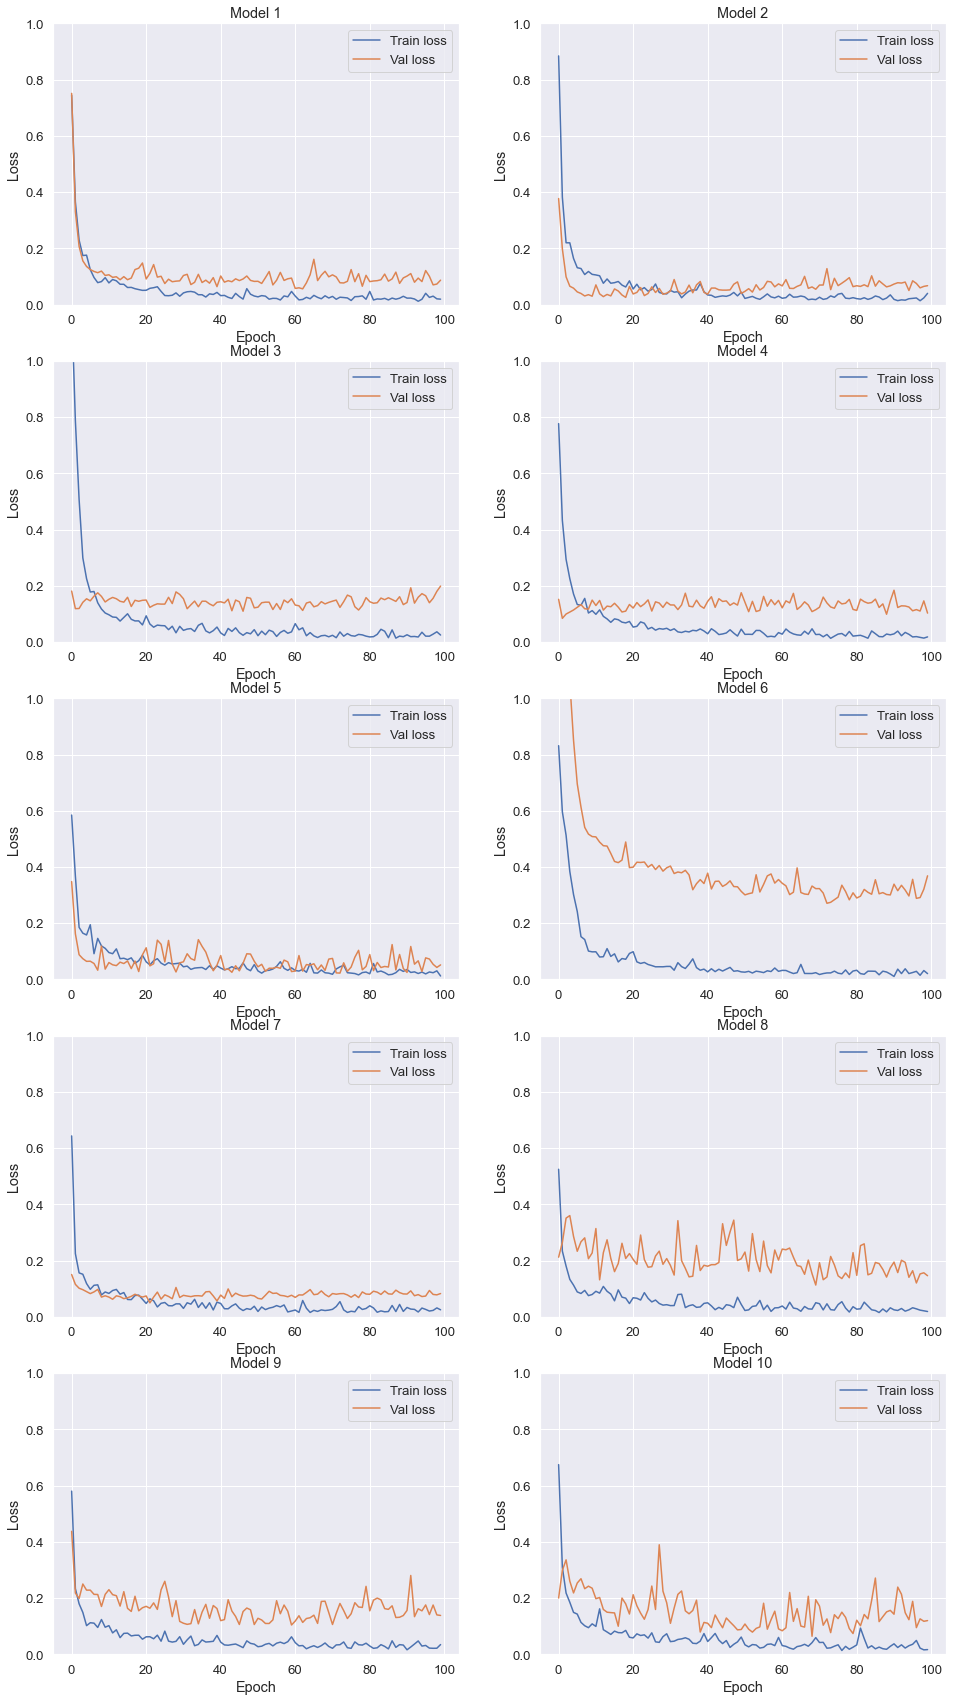

In [56]:
plot_history(models)

In [57]:
mean_mse = get_mean_mse(models)
mean_mse

0.13650745190680028

In [58]:
#'item_level', 'item_class' 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits'

tank_params = [[8, 2, 994.758446, 1051.125426, 41486.045662, 0.614389, 0.0, 0.054945, 4.0, 5.207303, 2978.862081, 5]]

best_model = get_best_model(models)

x = gold_scaler.transform(tank_params)[:,:len(tank_params[0])-1]
test_predictions = best_model.predict(x)
xx = np.concatenate((x[0], test_predictions[0]))
gold_scaler.inverse_transform(xx)[-1]

10700.98995962765

In [59]:
res_data[res_data['vehicle_type_cd'] == 9217][features]

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits


# Regression models (Dasha)

In [60]:
tank_classes = joined_data['item_class'].unique()

## Initial checks

### Check how item price in gold depends on the level for different item classes

In [ ]:
for tank_class in tank_classes:
    class_data = joined_data[joined_data['item_class'] == tank_class]
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(class_data['item_level'], class_data['item_price_gold']);
    plt.title(tank_class)

In [ ]:
joined_data_sample = joined_data.sample(n=10_000)

### Check how different characteristics correlate with item level

In [ ]:
features = np.setdiff1d(joined_data.columns.values, ['item_price_credit', 'item_price_gold', 'item_level', 'account_db_id'])
vehicle_classes = joined_data['item_class'].unique()

data_sample_ = joined_data_sample[joined_data_sample['item_class'] == 2]

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data_sample_['item_level'], data_sample_[feature]);

In [ ]:
joined_data_sample

### Check how many entries corresponding to every tank we have in the dataset

In [61]:
unique_tanks = joined_data[joined_data['item_price_credit'] > 0]['vehicle_type_cd'].value_counts()
unique_tanks

5377     28511
20481    21354
11521    20103
4353     17607
17473    17538
         ...  
15137       55
11585       27
8497        26
1889        24
9809         6
Name: vehicle_type_cd, Length: 239, dtype: int64

## Create different models

In [62]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.manifold import TSNE

In [63]:
mean_dataset = joined_data.groupby('vehicle_type_cd').mean()
regression_dataset = mean_dataset[mean_dataset['item_price_gold'] > 0]

regression_target = regression_dataset['item_price_gold']
regression_features = regression_dataset.drop(['item_price_gold', 'item_price_credit'], axis=1)

Introducing different regression models

In [158]:
models = [RandomForestRegressor(n_estimators=500, max_depth=8), 
          GradientBoostingRegressor(n_estimators=500, max_depth=8),
          SVR(kernel='rbf', C=100, gamma=0.001, epsilon=1),
          SVR(kernel='linear', C=100, epsilon=1),
          SVR(kernel='poly', C=1000, gamma=0.01, degree=2, epsilon=1, coef0=10)]

model_names = ['RandomForest', 'GradientBoost', 'SVM_rbf', 'SVM_linear', 'SVM_poly']

In [159]:
tt_split = 10
is_target_scaled=False
is_pca_used=True

mse_scores = pd.DataFrame(data=np.zeros((tt_split, len(models))),
                          columns=model_names)
r2_scores = pd.DataFrame(data=np.zeros((tt_split, len(models))), 
                         columns=model_names)

regression_results = dict.fromkeys(range(tt_split))

for tt in range(tt_split):
    x_train, x_test, y_train, y_test = train_test_split(regression_features, 
                                                        regression_target, 
                                                        test_size=0.3,
                                                        random_state=42)
    
    scaler = StandardScaler()
    # Scaling features
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if is_target_scaled:
        y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    else:
        y_train_scaled = y_train
        y_test_scaled = y_test
    
    # Removing collinearity between features
    if is_pca_used:
        pca_model = PCA(n_components=0.95)
        x_train_pca = pca_model.fit_transform(x_train_scaled)
        x_test_pca = pca_model.transform(x_test_scaled)
    else:
        x_train_pca = x_train_scaled
        x_test_pca = x_test_scaled
    
    results = y_test.values.reshape(-1, 1)
    for idx, model in enumerate(models):
        model.fit(x_train_pca, y_train_scaled)
        y_predicted = model.predict(x_test_pca)
        
        # Saving prediction results
        if is_target_scaled:
            results = np.hstack((results, scaler.inverse_transform(y_predicted).reshape(-1, 1)))
        else:
            results = np.hstack((results, y_predicted.reshape(-1, 1)))
    
        # Saving accuracy scores
        mse_scores.iloc[tt, idx] = mean_squared_error(y_test_scaled, y_predicted)
        r2_scores.iloc[tt, idx] = r2_score(y_test_scaled, y_predicted)
    
    # Saving prediction results
    regression_results[tt] = pd.DataFrame(data=results, index=x_test.index.values,
                                          columns=['y'] + model_names)

In [160]:
mse_scores

,RandomForest,GradientBoost,SVM_rbf,SVM_linear,SVM_poly
0,1.048730e+07,1.248274e+07,2.556908e+07,5.140236e+06,5.155836e+06
1,1.049026e+07,1.240770e+07,2.556908e+07,5.140236e+06,5.155836e+06
2,1.027313e+07,1.256923e+07,2.556908e+07,5.140236e+06,5.155836e+06
3,1.027646e+07,1.242862e+07,2.556908e+07,5.140236e+06,5.155836e+06
4,1.050275e+07,1.265740e+07,2.556908e+07,5.140236e+06,5.155836e+06
5,1.033004e+07,1.262731e+07,2.556908e+07,5.140236e+06,5.155836e+06
6,1.042454e+07,1.237564e+07,2.556908e+07,5.140236e+06,5.155836e+06
7,1.029158e+07,1.266451e+07,2.556908e+07,5.140236e+06,5.155836e+06
8,1.017704e+07,1.245367e+07,2.556908e+07,5.140236e+06,5.155836e+06
9,1.031109e+07,1.254366e+07,2.556908e+07,5.140236e+06,5.155836e+06


In [161]:
r2_scores

,RandomForest,GradientBoost,SVM_rbf,SVM_linear,SVM_poly
0,0.589131,0.510954,-0.00174,0.798617,0.798006
1,0.589015,0.513894,-0.00174,0.798617,0.798006
2,0.597522,0.507565,-0.00174,0.798617,0.798006
3,0.597391,0.513074,-0.00174,0.798617,0.798006
4,0.588525,0.504111,-0.00174,0.798617,0.798006
5,0.595292,0.505290,-0.00174,0.798617,0.798006
6,0.591589,0.515150,-0.00174,0.798617,0.798006
7,0.596798,0.503832,-0.00174,0.798617,0.798006
8,0.601286,0.512093,-0.00174,0.798617,0.798006
9,0.596034,0.508567,-0.00174,0.798617,0.798006


In [162]:
regression_results[0]

,y,RandomForest,GradientBoost,SVM_rbf,SVM_linear,SVM_poly
60177,7300.0,7836.219573,6922.933914,8320.164675,8686.122334,9184.302934
15617,22500.0,20852.000000,22499.999561,8672.037226,17799.502906,21476.519948
913,10700.0,10893.734717,11189.401332,8470.025804,11689.973438,11453.735051
61761,10700.0,9374.381720,10037.914873,8330.491586,8890.483646,9067.512366
57889,6500.0,6340.903248,5064.086018,8330.242466,7252.197142,6102.616576
58881,12000.0,10644.177415,11125.022807,8480.418912,11871.786852,11732.475675
52065,7400.0,8887.002683,7949.380428,8351.377004,8878.367812,9530.758712
55633,7300.0,8765.957023,8124.430946,8402.631754,9584.050124,9396.199537
63297,5000.0,5847.257692,4999.450400,8330.738654,4765.607082,4636.653227
15905,22500.0,20930.868750,22499.999561,8656.691548,18075.105556,22419.783545


Visualize best predictions

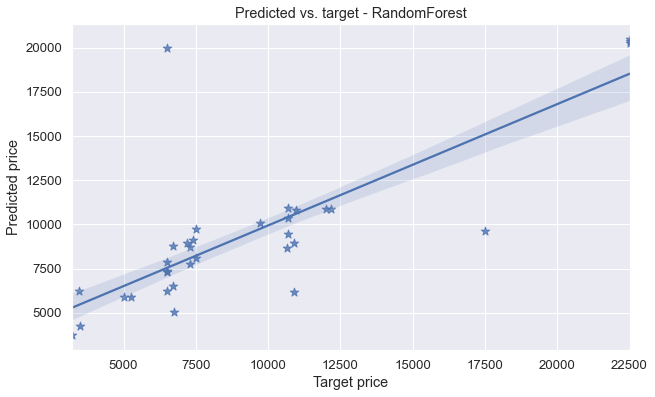

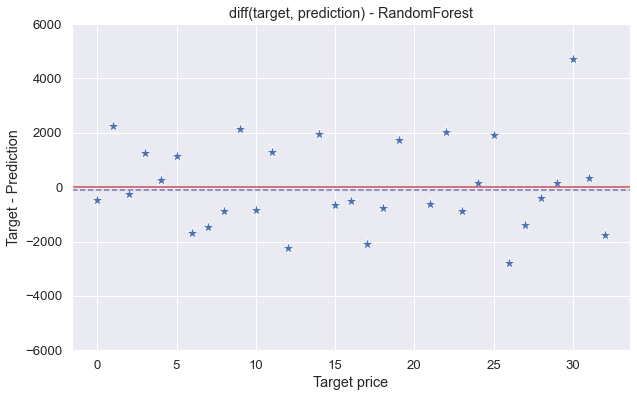

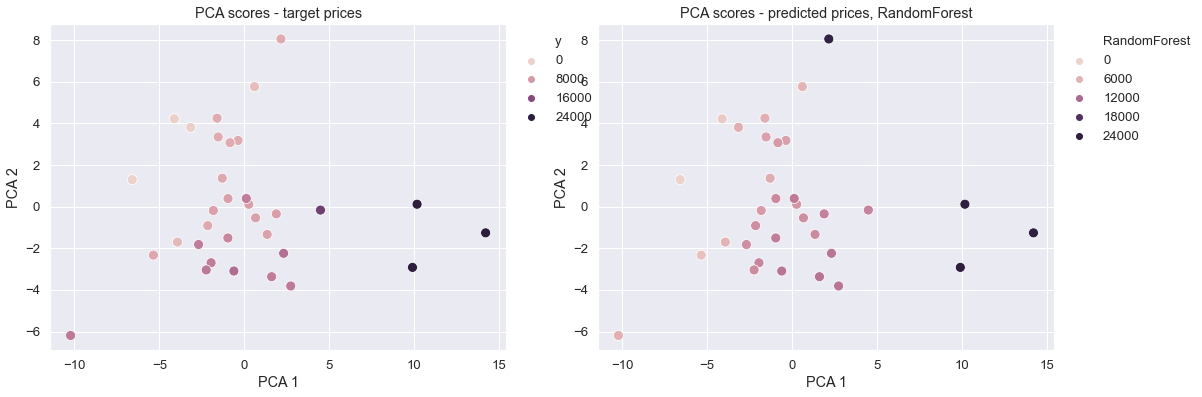

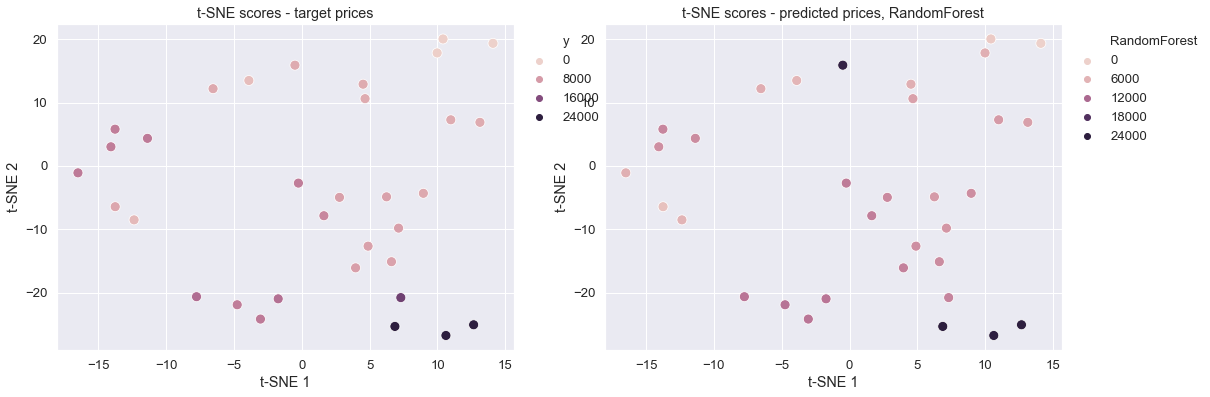

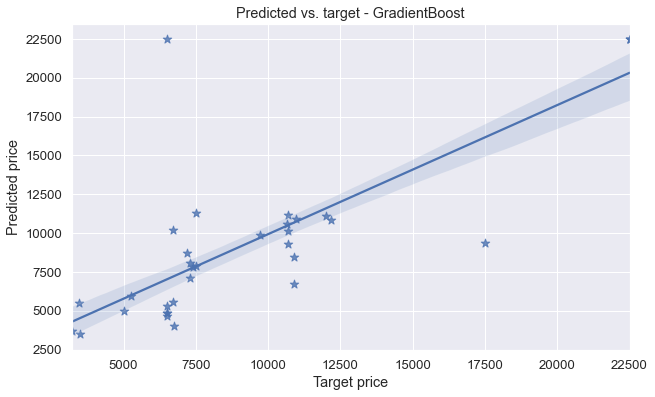

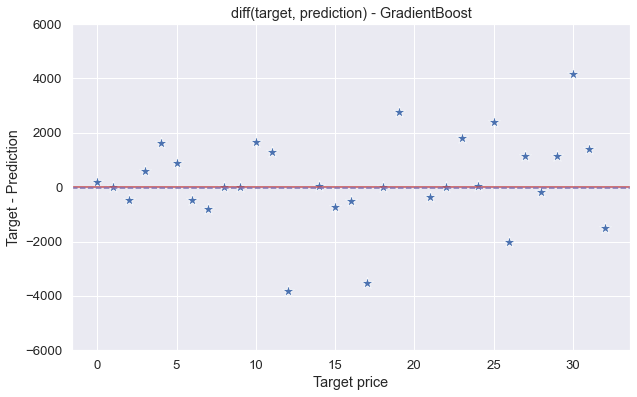

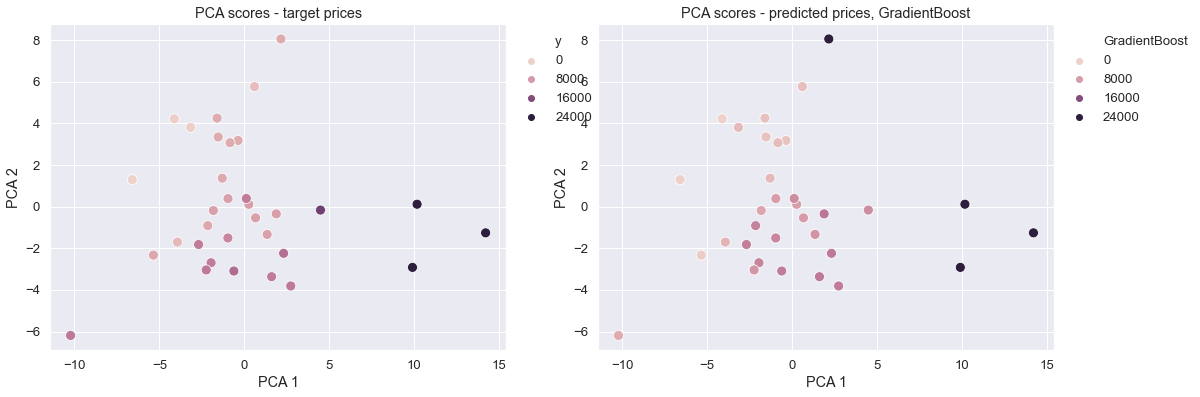

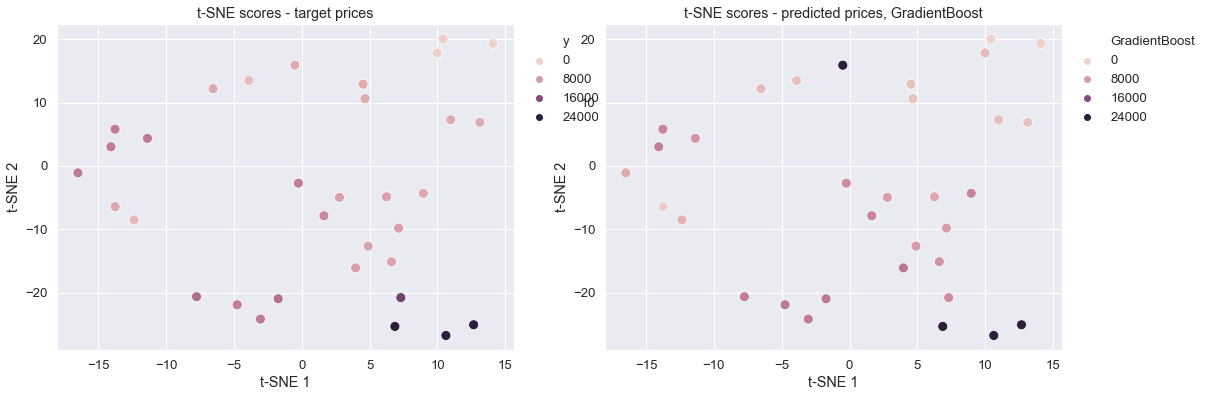

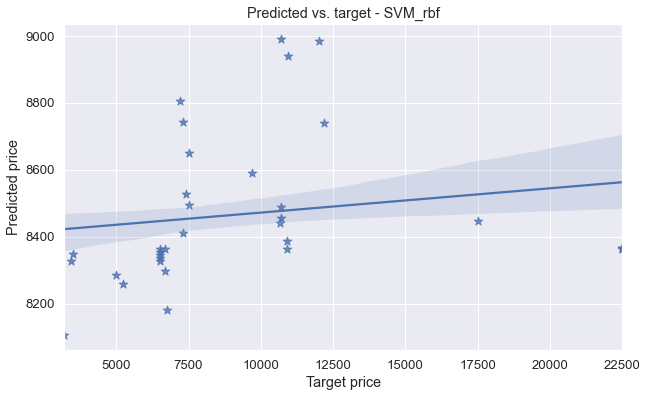

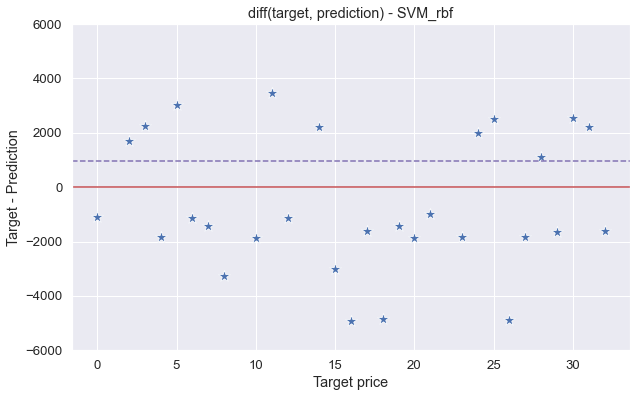

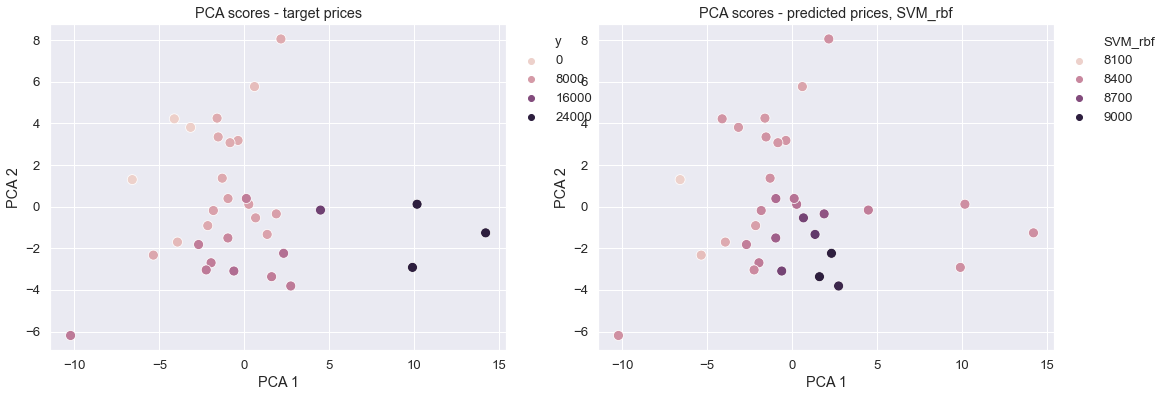

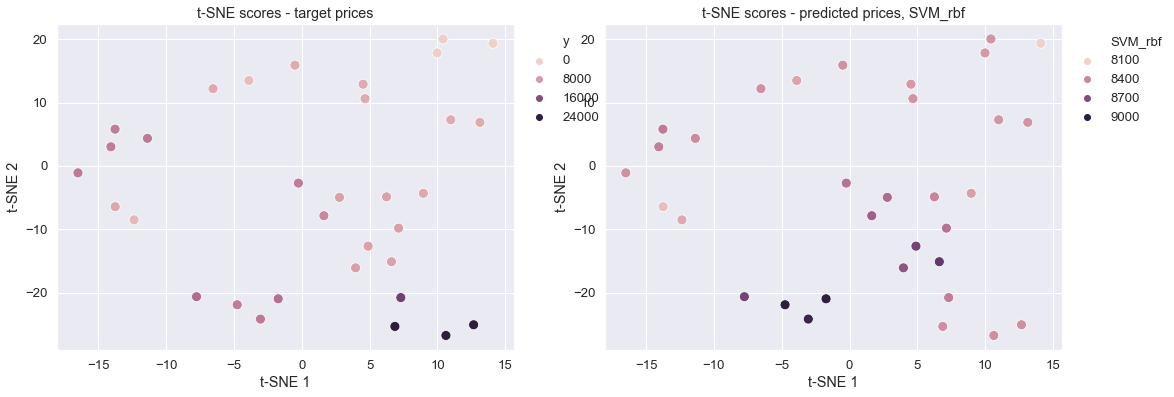

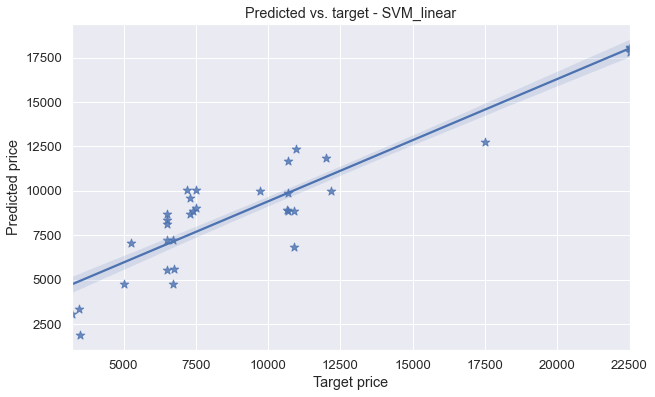

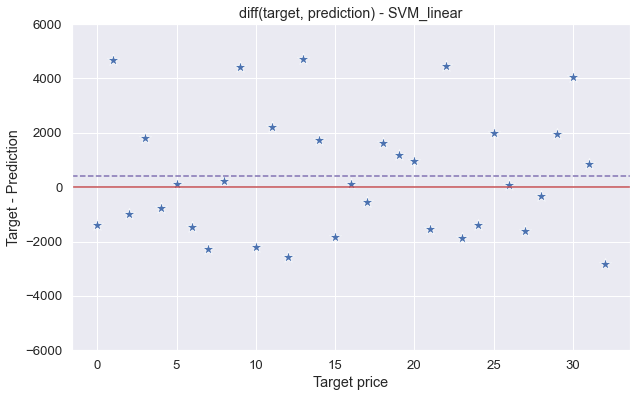

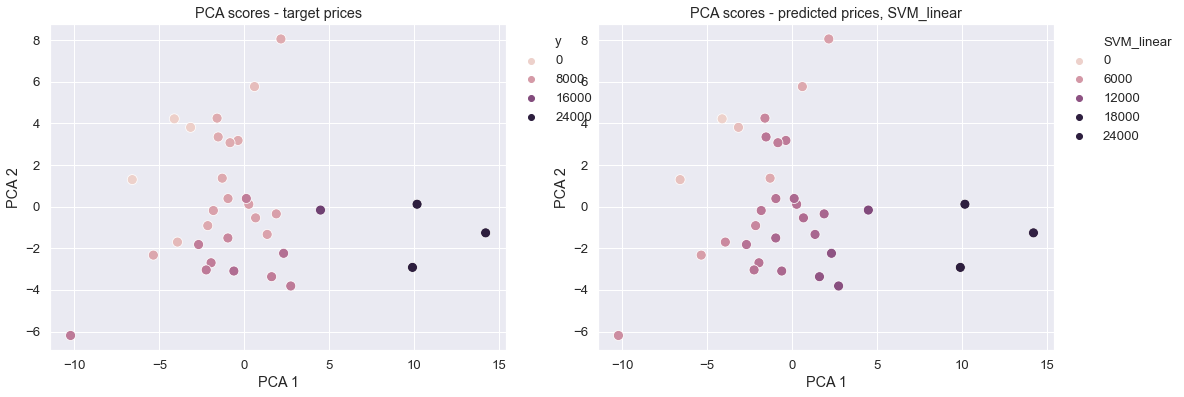

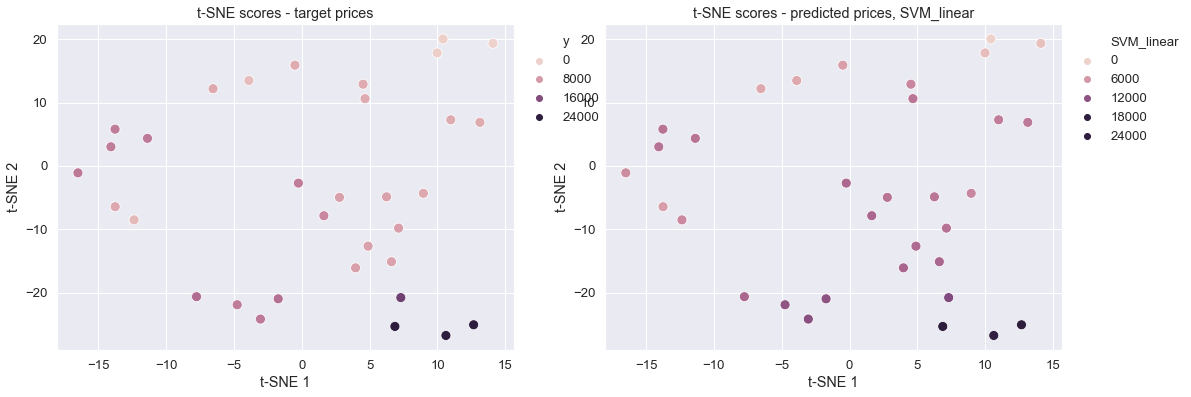

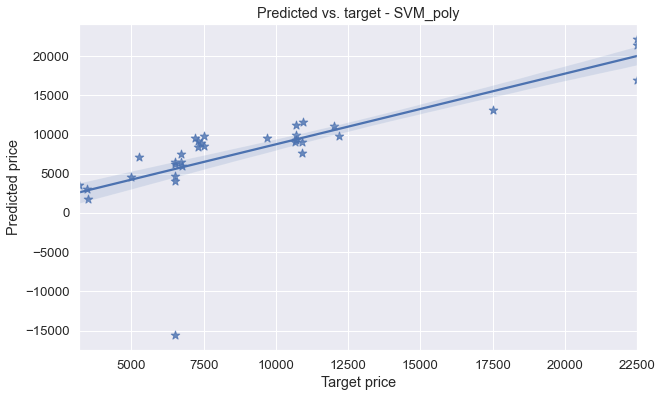

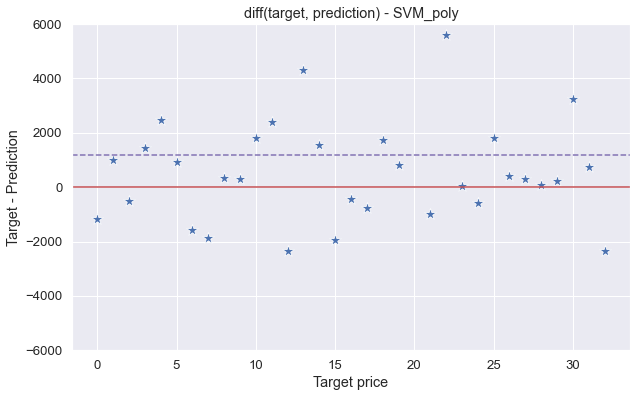

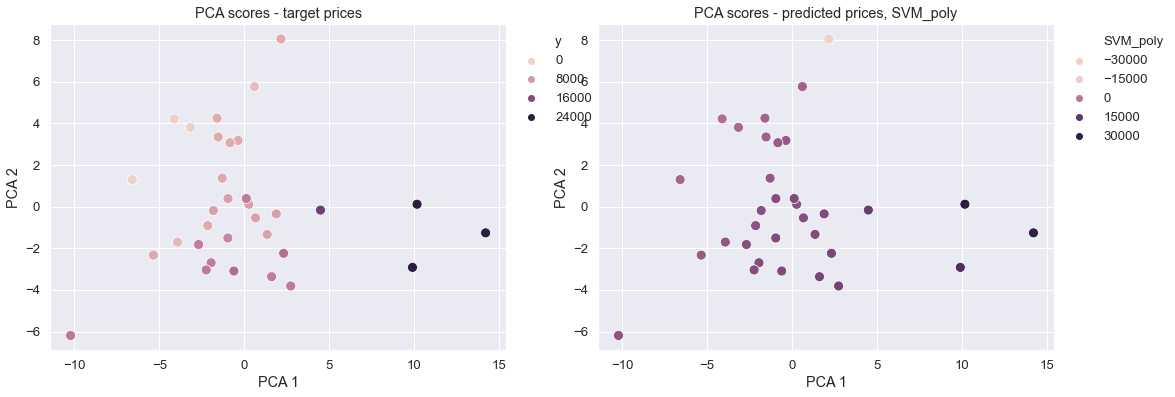

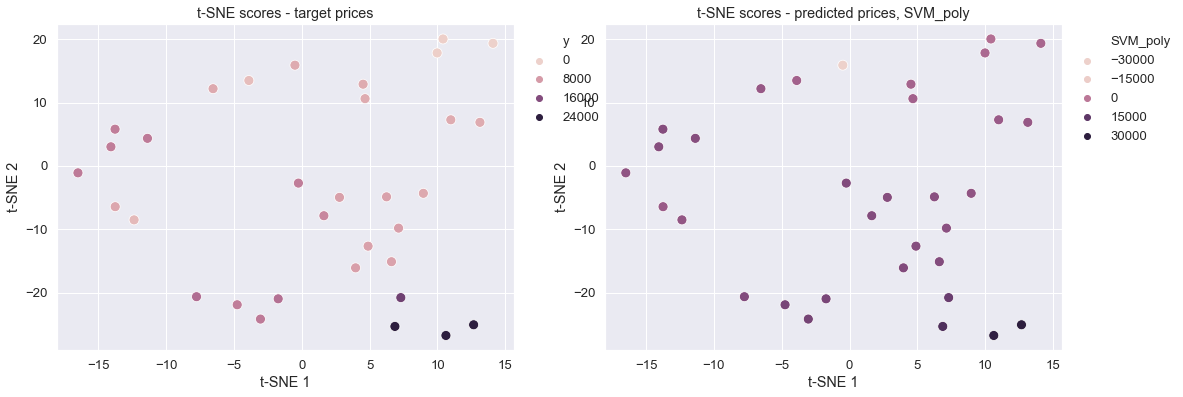

In [72]:
for model in model_names:
    best_prediction = mse_scores[model].idxmin()

    targets = [regression_results[best_prediction]['y'],
               regression_results[best_prediction][model]]

    compare_results(targets, [-6_000, 6_000], model)
    
    # Perform PCA and visualize results
    items = regression_features.loc[regression_results[best_prediction][model].index]
    pca_items = perform_pca(items)

    visualize_data(pca_items, targets, model, dr_type='PCA')
    
    # Perform TSNE and visualize results
    tsne_items = TSNE(n_components=2, perplexity=5, learning_rate=10, init='pca').fit_transform(pca_items)
    
    visualize_data(tsne_items, targets, model, dr_type='t-SNE')

### Use Sequential Feature Selection (with Random Forest)

In [ ]:
# tt_split = 10

# mse_scores = np.zeros((tt_split, 2))

# for tt in range(tt_split):
#     x_train, x_test, y_train, y_test = train_test_split(regression_features, 
#                                                         regression_target, 
#                                                         test_size=0.3)
    
#     scaler = StandardScaler()
#     # Scaling features
#     x_train_scaled = scaler.fit_transform(x_train)
#     x_test_scaled = scaler.transform(x_test)
#     # Scaling targets
#     y_train_scaled = scaler.fit_transform(y_train)
#     y_test_scaled = scaler.transform(y_test)
    
#     rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, 
#                                      random_state=0, n_jobs=8)
    
#     feature_selector = SFS(rf_model, 
#                            k_features=(2, 10), 
#                            forward=True, 
#                            floating=False, 
#                            verbose=2,
#                            scoring='neg_mean_squared_error',
#                            n_jobs=2,
#                            cv=0)
    
#     x_train_selected = feature_selector.fit_transform(x_train_scaled, 
#                                                       y_train_scaled)
#     x_test_selected = feature_selector.transform(x_test_scaled)
    
#     rf_model.fit(x_train_selected, y_train_scaled)
#     y_predicted = rf_model.predict(x_test_selected)
    
#     mse_scores[tt, 0] = mean_squared_error(y_test_scaled, y_predicted)
#     mse_scores[tt, 1] = r2_score(y_test, y_predicted)

# Player segmentation

In [ ]:
# Save data before switching to player segmentation
data.to_csv("data_cleaned.csv");

In [ ]:
joined_data.to_csv("joined_data_cleaned.csv");

In [ ]:
data.info()

In [ ]:
players.info()

In [ ]:
players.dropna(inplace=True)

In [ ]:
player_features = ['hit_rate', 'pierced_rate', 'damage_per_enemy', 
                  'damage_blocked_received_ratio', 'kills_made_per_min',
                  'total_damage_dealt']
players_data = players[player_features]

In [ ]:
players[players['life_time_sec'] == 0]

In [ ]:
players

## Посмотреть на клановых игроков и игроков без клана

In [ ]:
data.head()

In [ ]:
clans_per_player = data.groupby('account_db_id')['clan_db_id'].nunique().sort_values(ascending=False)
clans_per_player

In [ ]:
multiple_clan_data = data[data.groupby('account_db_id')['clan_db_id'].transform('count') > 1]
multiple_clan_players = multiple_clan_data.groupby('account_db_id').mean()
multiple_clan_players

In [ ]:
single_clan_players = data[data.groupby('account_db_id')['clan_db_id'].transform('count') == 1]
single_clan_players

In [ ]:
players = data.drop(['arena_id', 'team_id', 'vehicle_type_cd'], axis=1).groupby('account_db_id').mean()

In [ ]:
player_features = ['life_time_sec', 'shots_per_min', 'hits_per_min',
                   'he_hits_per_min', 'pierced_per_min', 'damage_dealt_per_min',
                   'damage_assisted_track_per_min', 'damage_assisted_radio_per_min',
                   'damage_assisted_stun_per_min', 'total_damage_dealt_per_min',
                   'damage_received_per_min', 'shots_received_per_min',
                   'pierced_received_per_min', 'spotted_per_min', 'damaged_per_min',
                   'kills_made_per_min', 'mileage_meter_per_min',
                   'damage_blocked_by_armor_per_min', 'hit_rate', 'he_hit_rate',
                   'pierced_rate', 'damage_per_pierced', 'pierced_received_per_shot',
                   'damage_per_enemy',
                   'damage_blocked_per_hit', 'damage_blocked_received_ratio']

for feature in player_features:
    plt.figure(figsize=(8, 6));
    sns.distplot(players[players['clan_db_id'] == 0][feature], kde=False);
    sns.distplot(players[players['clan_db_id'] != 0][feature], kde=False);

In [ ]:
players_data = players[['life_time_sec', 'shots_per_min', 'hits_per_min', 
                         'hit_rate', 'damage_per_pierced', 
                         'damage_per_enemy']]

In [ ]:
scaler = StandardScaler()
players_scaled = scaler.fit_transform(players_data)

pca_model = PCA(n_components=0.95, svd_solver='full')
players_pca = pca_model.fit_transform(players_scaled)

In [ ]:
players_pca

In [ ]:
sns.scatterplot(players_pca[:, 0], players_pca[:, 1]);

In [ ]:
data['arena_id'].unique()

In [ ]:
full_team_index = (data.groupby('arena_id')['account_db_id'].count() == 30)
full_team_index

In [ ]:
full_team_battles = data['arena_id'].value_counts().sort_index(ascending=True)[full_team_index]
full_team_battles

In [ ]:
full_team_battles = full_team_battles.index.values.astype('str')
full_team_battles

In [ ]:
data_copy = data.copy(deep=True)
data_copy[data_copy['arena_id'].isin(full_team_battles)]

In [ ]:
(data_copy.groupby('arena_id')['account_db_id'].count() != 30).sum()

In [ ]:
pl = data.groupby('arena_id').filter(lambda g: g['account_db_id'].count() == 30)

In [ ]:
(pl.groupby('arena_id')['account_db_id'].count() != 30).sum()

In [ ]:
gg = pl.groupby('arena_id').nunique()

In [ ]:
gg